# Credit Risk Modeling | Part 3: Loss Given Default, Exposure at Default, and Expected Loss


## Introduction

After estimating the probability of default (PD) in previous steps, credit risk assessment proceeds with quantifying the **Loss Given Default (LGD)** and **Exposure at Default (EAD)**—the other two core components of expected credit loss.

### Key Definitions and Formulas

- **Loss Given Default (LGD):**  
  LGD represents the proportion of total exposure that is lost if a borrower defaults, after accounting for recoveries.  
  $$ \mathrm{LGD} = 1 - \mathrm{Recovery\ Rate} $$
  LGD is typically expressed as a percentage (e.g., 60% means 60 cents lost per dollar at default).

- **Exposure at Default (EAD):**  
  EAD is the total value that the lender is exposed to when the borrower defaults. For term loans, this is usually the outstanding principal at the time of default.

- **Expected Loss (EL):**  
  EL combines all three risk components into a single measure of anticipated loss:  
  $$
  \mathrm{EL} = \mathrm{PD} \times \mathrm{EAD} \times \mathrm{LGD}
  $$
  Where:
  - PD: Probability of Default (from earlier modeling)
  - LGD: Loss Given Default
  - EAD: Exposure at Default

**Expected Loss** is a foundational metric for risk-based capital requirements, pricing, and provisioning under Basel and IFRS 9 frameworks.

---

In this notebook, we will:
- Model and estimate LGD and EAD using appropriate statistical techniques,
- Calculate account-level and portfolio-level Expected Loss (EL),
- Prepare the data for risk-based decision making and regulatory compliance.


# 1 Data Preparation

## a Import Libraries






In [319]:
#installing gdown package to download dataset stored in G Drive
!pip install gdown

# to upgrade
!pip install --upgrade gdown


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: pip install --upgrade pip


In [320]:
import numpy as np
import pandas as pd

#libs for plotting
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

#ML model
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import roc_curve, roc_auc_score

import scipy.stats as stat

#exporting ML model
import pickle

#lib to download dataset on g drive
import gdown

#setting display option max rows
#pd.options.display.max_rows = None

## b Import Data

Please note that if you have already run the first notebook of this series, you don't need to run the codes below and so download the data sets.

In [321]:
#installing gdown package to download dataset stored in G Drive
!pip install gdown
# to upgrade
!pip install --upgrade gdown


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: pip install --upgrade pip


In [322]:
# 1st file
url_1 = "https://drive.google.com/uc?id=1v45P0HhUxZ1x4HmD0bWblpUyUWuiC0_5"
output_1 = "loan_data_inputs_train.csv"
gdown.download(url_1, output_1, quiet=False)

# 2nd file
url_2 = "https://drive.google.com/uc?id=1KvP7EXfVNdekotGFqgp9UUlNXBLCKy9i"
output_2 = "loan_data_targets_train.csv"
gdown.download(url_2, output_2, quiet=False)


Downloading...
From (original): https://drive.google.com/uc?id=1v45P0HhUxZ1x4HmD0bWblpUyUWuiC0_5
From (redirected): https://drive.google.com/uc?id=1v45P0HhUxZ1x4HmD0bWblpUyUWuiC0_5&confirm=t&uuid=88ddadeb-7e57-4892-a43b-7a0eac508db7
To: /Users/aish7/Documents/Credit_Risk_Modelling/notebooks/loan_data_inputs_train.csv
100%|██████████| 436M/436M [00:16<00:00, 26.1MB/s] 
Downloading...
From: https://drive.google.com/uc?id=1KvP7EXfVNdekotGFqgp9UUlNXBLCKy9i
To: /Users/aish7/Documents/Credit_Risk_Modelling/notebooks/loan_data_targets_train.csv
100%|██████████| 3.27M/3.27M [00:00<00:00, 17.0MB/s]


'loan_data_targets_train.csv'

In [318]:

import gdown

# 3rd file
url3 = "https://drive.google.com/uc?id=1M-VHZM612ihx-elO6dw3SVYJh0cWD5E6"
output3 = "loan_data_inputs_test.csv"
gdown.download(url3, output3, quiet=False)

# 4th file
url4 = "https://drive.google.com/uc?id=1wTkfTDyCxcMcddsz-Fk-AO_Y6owLhzWp"
output4 = "loan_data_targets_test.csv"
gdown.download(url4, output4, quiet=False)


Downloading...
From (original): https://drive.google.com/uc?id=1M-VHZM612ihx-elO6dw3SVYJh0cWD5E6
From (redirected): https://drive.google.com/uc?id=1M-VHZM612ihx-elO6dw3SVYJh0cWD5E6&confirm=t&uuid=2c48908a-b896-45e1-9ece-aecb63e1a984
To: /Users/aish7/Documents/Credit_Risk_Modelling/notebooks/loan_data_inputs_test.csv
100%|██████████| 109M/109M [00:04<00:00, 26.9MB/s] 
Downloading...
From: https://drive.google.com/uc?id=1wTkfTDyCxcMcddsz-Fk-AO_Y6owLhzWp
To: /Users/aish7/Documents/Credit_Risk_Modelling/notebooks/loan_data_targets_test.csv
100%|██████████| 817k/817k [00:00<00:00, 8.17MB/s]


'loan_data_targets_test.csv'

In [323]:
#import data
df1 = pd.read_csv("loan_data_inputs_train.csv", index_col = 0)
df2 = pd.read_csv("loan_data_inputs_test.csv", index_col = 0)


In [324]:
df1.head()

,Unnamed: 0,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,...,dti:21.7-22.4,dti:22.4-35,dti:>35,mths_since_last_record:Missing,mths_since_last_record:0-2,mths_since_last_record:3-20,mths_since_last_record:21-31,mths_since_last_record:32-80,mths_since_last_record:81-86,mths_since_last_record:>=86
427211,427211,12796369,14818505,24000,24000,24000.0,36 months,8.90,762.08,A,...,1,0,0,1,0,0,0,0,0,0
206088,206088,1439740,1691948,10000,10000,10000.0,36 months,14.33,343.39,C,...,0,0,0,1,0,0,0,0,0,0
136020,136020,5214749,6556909,20425,20425,20425.0,36 months,8.90,648.56,A,...,0,0,0,1,0,0,0,0,0,0
412305,412305,13827698,15890016,17200,17200,17200.0,36 months,16.59,609.73,D,...,0,0,0,1,0,0,0,0,0,0
36159,36159,422455,496525,8400,8400,7450.0,36 months,12.84,282.40,C,...,0,1,0,1,0,0,0,0,0,0


In [325]:
df2.head()

,Unnamed: 0,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,...,dti:21.7-22.4,dti:22.4-35,dti:>35,mths_since_last_record:Missing,mths_since_last_record:0-2,mths_since_last_record:3-20,mths_since_last_record:21-31,mths_since_last_record:32-80,mths_since_last_record:81-86,mths_since_last_record:>=86
362514,362514,19677589,21900299,32500,32500,32500.0,60 months,14.99,773.01,C,...,0,0,0,1,0,0,0,0,0,0
288564,288564,29755527,32278795,11000,11000,11000.0,60 months,20.99,297.53,E,...,0,1,0,1,0,0,0,0,0,0
213591,213591,1343334,1588314,30000,30000,30000.0,36 months,14.65,1034.83,C,...,0,0,0,1,0,0,0,0,0,0
263083,263083,33131681,35775007,14400,14400,14400.0,60 months,14.49,338.74,C,...,0,0,0,1,0,0,0,0,0,0
165001,165001,3293168,4066358,15000,15000,14900.0,36 months,8.90,476.30,A,...,0,0,0,1,0,0,0,0,0,0


In [326]:
loan_data_preprocessed  = pd.concat([df1,df2],axis=0) #'loan_data_2007_2014_preprocessed.csv')
df1, df2 = [], [] #deleting the df s that use a large amount of ram source

## c Filtering defaulted account data

In [327]:
# We only need the data on the accounts that were charged-off (written-off).
loan_data_defaults = loan_data_preprocessed[loan_data_preprocessed['loan_status'].\
                                            isin(['Charged Off','Does not meet the credit policy. Status:Charged Off'])]

In [328]:
loan_data_defaults.shape

(43236, 315)

##d Independent Variables

In [329]:
# Let's fill missing values with zeroes.
loan_data_defaults['mths_since_last_delinq'].fillna(0, inplace = True)

/var/folders/y6/98pzw41d19qg3qhnh3w7nxdh00cyh4/T/ipykernel_3280/2556160213.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  loan_data_defaults['mths_since_last_delinq'].fillna(0, inplace = True)
/var/folders/y6/98pzw41d19qg3qhnh3w7nxdh00cyh4/T/ipykernel_3280/2556160213.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loan_data_defaults['

In [330]:
# Let's fill the missing values with zeroes.
loan_data_defaults['mths_since_last_record'].fillna(0, inplace=True)

/var/folders/y6/98pzw41d19qg3qhnh3w7nxdh00cyh4/T/ipykernel_3280/2917393115.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  loan_data_defaults['mths_since_last_record'].fillna(0, inplace=True)
/var/folders/y6/98pzw41d19qg3qhnh3w7nxdh00cyh4/T/ipykernel_3280/2917393115.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loan_data_defaults['mt

## e Dependent Variables

### i- Recovery rate

In [331]:
# For the LGD model, We need to calculate the dependent variable recovery rate.
# It is the ratio of recoveries and funded amount.
loan_data_defaults['recovery_rate'] = loan_data_defaults['recoveries'] / loan_data_defaults['funded_amnt']

/var/folders/y6/98pzw41d19qg3qhnh3w7nxdh00cyh4/T/ipykernel_3280/3408728853.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loan_data_defaults['recovery_rate'] = loan_data_defaults['recoveries'] / loan_data_defaults['funded_amnt']


In [332]:
# Let's check out some descriptive statisics for the values of a column.
loan_data_defaults['recovery_rate'].describe()

count    43236.000000
mean         0.060820
std          0.089770
min          0.000000
25%          0.000000
50%          0.029466
75%          0.114044
max          1.220774
Name: recovery_rate, dtype: float64

In [333]:
# We have some recovery rate data > 1.0.
# We need to set recovery rates that are greater than 1 to 1 
loan_data_defaults['recovery_rate'] = np.where(loan_data_defaults['recovery_rate'] > 1, 1, loan_data_defaults['recovery_rate'])
# We need to set recovery rates that are less than 0 to 0. (this part is kept for a future dataset)
loan_data_defaults['recovery_rate'] = np.where(loan_data_defaults['recovery_rate'] < 0, 0, loan_data_defaults['recovery_rate'])


/var/folders/y6/98pzw41d19qg3qhnh3w7nxdh00cyh4/T/ipykernel_3280/3985910929.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loan_data_defaults['recovery_rate'] = np.where(loan_data_defaults['recovery_rate'] > 1, 1, loan_data_defaults['recovery_rate'])
/var/folders/y6/98pzw41d19qg3qhnh3w7nxdh00cyh4/T/ipykernel_3280/3985910929.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loan_data_defaults['recovery_rate'] = np.where(loan_data_defaults['recovery_rate'] < 0, 0, loan_data_defaults['recovery_rate'])


In [334]:
#let's check if all is good after data cleaning
loan_data_defaults['recovery_rate'].describe()

count    43236.000000
mean         0.060770
std          0.089202
min          0.000000
25%          0.000000
50%          0.029466
75%          0.114044
max          1.000000
Name: recovery_rate, dtype: float64

### ii- CCF

In [335]:
# let's calculate the dependent variable for the EAD model: credit conversion factor.
# It is the ratio of the difference of the amount used at the moment of default to the total funded amount.
loan_data_defaults['CCF'] = (loan_data_defaults['funded_amnt'] - \
                             loan_data_defaults['total_rec_prncp']) / loan_data_defaults['funded_amnt']


/var/folders/y6/98pzw41d19qg3qhnh3w7nxdh00cyh4/T/ipykernel_3280/4161659530.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loan_data_defaults['CCF'] = (loan_data_defaults['funded_amnt'] - \


In [336]:
loan_data_defaults['CCF'].describe()
# Shows some descriptive statisics for the values of a column.

count    43236.000000
mean         0.735952
std          0.200742
min          0.000438
25%          0.632088
50%          0.789908
75%          0.888543
max          1.000000
Name: CCF, dtype: float64

(array([  10.,   21.,   49.,   21.,   51.,   54.,   21.,  103.,   30.,
          93.,   73.,   62.,   96.,   63.,  135.,   99.,  116.,  145.,
         125.,  162.,  140.,  178.,  162.,  178.,  213.,  194.,  228.,
         209.,  258.,  248.,  275.,  263.,  295.,  326.,  372.,  312.,
         409.,  367.,  382.,  420.,  454.,  475.,  528.,  525.,  515.,
         573.,  554.,  655.,  636.,  718.,  742.,  861.,  809.,  965.,
         873., 1105., 1033., 1182., 1130., 1270., 1317., 1360., 1477.,
        1327., 1715., 1457., 1803., 1463., 1874., 1520., 1393., 1568.,
         750.,  999.,  652.]),
 array([4.38000000e-04, 1.37654933e-02, 2.70929867e-02, 4.04204800e-02,
        5.37479733e-02, 6.70754667e-02, 8.04029600e-02, 9.37304533e-02,
        1.07057947e-01, 1.20385440e-01, 1.33712933e-01, 1.47040427e-01,
        1.60367920e-01, 1.73695413e-01, 1.87022907e-01, 2.00350400e-01,
        2.13677893e-01, 2.27005387e-01, 2.40332880e-01, 2.53660373e-01,
        2.66987867e-01, 2.80315360e-01, 2

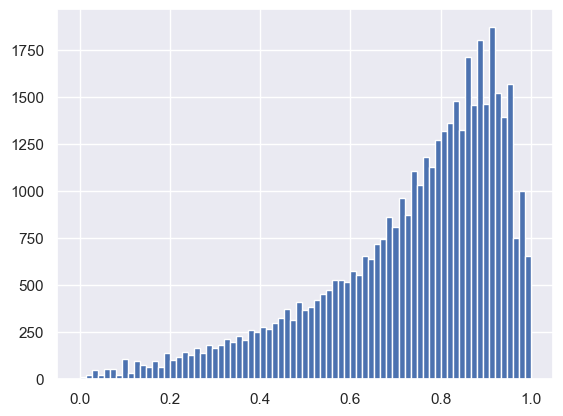

In [337]:
# Plotting a histogram of CCF
plt.hist(loan_data_defaults['CCF'], bins = 75)

In [338]:
# Creating a new variable showing 0 for recovery rate being 0 and 1 otherwise.
loan_data_defaults['recovery_rate_0_1'] = np.where(loan_data_defaults['recovery_rate'] == 0, 0, 1)

/var/folders/y6/98pzw41d19qg3qhnh3w7nxdh00cyh4/T/ipykernel_3280/2919436691.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loan_data_defaults['recovery_rate_0_1'] = np.where(loan_data_defaults['recovery_rate'] == 0, 0, 1)


## f Exporting data

In [339]:
#saving the data in a csv file
loan_data_defaults.to_csv('../data/loan_data_defaults.csv')

#2 LGD Model

LGD is the amount outstanding we expect to lose. It is a proportion of the total exposure when borrower defaults. It is a percentage of total exposure at the time of default or a single dollar value of potential loss. It is calculated by (1 - Recovery Rate). 

The model will be created in two steps:
*  Step 1- recovery rate is equal to/greater than 0

*  Step 2- recovery rate is equal to/greater than 1

### a Step 1 --- Logistic Regression

In [340]:
# LGD model step 1 datasets: recovery rate 0 or greater than 0.
# Considering a set of inputs [all cols except recovery rate and CCF] and outputs[recovery_rate_0_1]. Splits the inputs and the targets into four dataframes:
# Inputs - Train n Test, Targets - Train n Test
lgd_X_S1 = loan_data_defaults.drop([ 'recovery_rate','recovery_rate_0_1', 'CCF'], axis = 1)
lgs_Y_S1 = loan_data_defaults['recovery_rate_0_1']

lgd_X_S1_train, lgd_X_S1_test, lgd_Y_S1_train, lgd_Y_S1_test = train_test_split(lgd_X_S1, lgs_Y_S1, test_size = 0.2, random_state = 42)

In [341]:
# List of all X variables for the models.
features_all = ['grade:A',
'grade:B',
'grade:C',
'grade:D',
'grade:E',
'grade:F',
'grade:G',
'home_ownership:MORTGAGE',
'home_ownership:NONE',
'home_ownership:OTHER',
'home_ownership:OWN',
'home_ownership:RENT',
'verification_status:Not Verified',
'verification_status:Source Verified',
'verification_status:Verified',
'purpose:car',
'purpose:credit_card',
'purpose:debt_consolidation',
'purpose:educational',
'purpose:home_improvement',
'purpose:house',
'purpose:major_purchase',
'purpose:medical',
'purpose:moving',
'purpose:other',
'purpose:renewable_energy',
'purpose:small_business',
'purpose:vacation',
'purpose:wedding',
'initial_list_status:f',
'initial_list_status:w',
'term_int',
'emp_length_int',
'mths_since_issue_d',
'mths_since_earliest_cr_line',
'funded_amnt',
'int_rate',
'installment',
'annual_inc',
'dti',
'delinq_2yrs',
'inq_last_6mths',
'mths_since_last_delinq',
'mths_since_last_record',
'open_acc',
'pub_rec',
'total_acc',
'acc_now_delinq',
'total_rev_hi_lim']

In [342]:
# List of the dummy X variables, avoiding dummy trick reference categories. 
features_reference_cat = ['grade:G',
'home_ownership:RENT',
'verification_status:Verified',
'purpose:credit_card',
'initial_list_status:f']


In [343]:
# Here we keep only the variables we need for the model.
lgd_X_S1_train = lgd_X_S1_train[features_all]
# Here we remove the dummy variable reference categories.
lgd_X_S1_train = lgd_X_S1_train.drop(features_reference_cat, axis = 1)


In [344]:
lgd_X_S1_train.isnull().sum()
# Check for missing values. We check whether the value of each row for each column is missing or not,
# then sum accross columns.

grade:A                                0
grade:B                                0
grade:C                                0
grade:D                                0
grade:E                                0
grade:F                                0
home_ownership:MORTGAGE                0
home_ownership:NONE                    0
home_ownership:OTHER                   0
home_ownership:OWN                     0
verification_status:Not Verified       0
verification_status:Source Verified    0
purpose:car                            0
purpose:debt_consolidation             0
purpose:educational                    0
purpose:home_improvement               0
purpose:house                          0
purpose:major_purchase                 0
purpose:medical                        0
purpose:moving                         0
purpose:other                          0
purpose:renewable_energy               0
purpose:small_business                 0
purpose:vacation                       0
purpose:wedding 

In [345]:
import numpy as np
import statsmodels.api as sm
from sklearn.base import BaseEstimator

class LogisticRegression_with_p_values(BaseEstimator):
    def __init__(self):
        self.model = None
        self.results = None

    def fit(self, X, y):
        X_const = sm.add_constant(X)
        self.model = sm.Logit(y, X_const)
        self.results = self.model.fit(disp=False)
        return self

    def predict(self, X):
        X_const = sm.add_constant(X)
        return (self.results.predict(X_const) >= 0.5).astype(int)

    def summary(self):
        return self.results.summary()

    def pvalues(self):
        return self.results.pvalues


In [346]:
print(lgd_X_S1_train.dtypes)
print(lgd_X_S1_train.isnull().sum())

print(lgd_Y_S1_train.dtypes)
print(lgd_Y_S1_train.isnull().sum())



grade:A                                  int64
grade:B                                  int64
grade:C                                  int64
grade:D                                  int64
grade:E                                  int64
grade:F                                  int64
home_ownership:MORTGAGE                  int64
home_ownership:NONE                      int64
home_ownership:OTHER                     int64
home_ownership:OWN                       int64
verification_status:Not Verified         int64
verification_status:Source Verified      int64
purpose:car                              int64
purpose:debt_consolidation               int64
purpose:educational                      int64
purpose:home_improvement                 int64
purpose:house                            int64
purpose:major_purchase                   int64
purpose:medical                          int64
purpose:moving                           int64
purpose:other                            int64
purpose:renew

In [347]:
import numpy as np

# Make sure indexes align (reset if needed)
lgd_X_S1_train = lgd_X_S1_train.reset_index(drop=True)
lgd_Y_S1_train = lgd_Y_S1_train.reset_index(drop=True)

# Convert boolean columns explicitly to integers (0/1)
lgd_X_S1_train = lgd_X_S1_train.astype(int)

# Convert target to int if not already
lgd_Y_S1_train = lgd_Y_S1_train.astype(int)

# Check again
print(lgd_X_S1_train.dtypes)
print(lgd_Y_S1_train.dtypes)


grade:A                                int64
grade:B                                int64
grade:C                                int64
grade:D                                int64
grade:E                                int64
grade:F                                int64
home_ownership:MORTGAGE                int64
home_ownership:NONE                    int64
home_ownership:OTHER                   int64
home_ownership:OWN                     int64
verification_status:Not Verified       int64
verification_status:Source Verified    int64
purpose:car                            int64
purpose:debt_consolidation             int64
purpose:educational                    int64
purpose:home_improvement               int64
purpose:house                          int64
purpose:major_purchase                 int64
purpose:medical                        int64
purpose:moving                         int64
purpose:other                          int64
purpose:renewable_energy               int64
purpose:sm

In [348]:
X_np = lgd_X_S1_train.values
y_np = lgd_Y_S1_train.values

In [349]:
# We create an instance of an object from the 'LogisticRegression' class.
reg_lgd_st_1 = LogisticRegression_with_p_values()


# Estimating the coefficients of the object from the 'LogisticRegression' class
# with X (independent variables) from the first dataframe
# and Y (dependent variables) from the second dataframe.
reg_lgd_st_1.fit(lgd_X_S1_train, lgd_Y_S1_train)
print(reg_lgd_st_1.summary())

                           Logit Regression Results                           
Dep. Variable:      recovery_rate_0_1   No. Observations:                34588
Model:                          Logit   Df Residuals:                    34543
Method:                           MLE   Df Model:                           44
Date:                Thu, 07 Aug 2025   Pseudo R-squ.:                 0.08480
Time:                        12:29:52   Log-Likelihood:                -21674.
converged:                      False   LL-Null:                       -23682.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                          coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
const                                  -4.4242      0.269    -16.418      0.000      -4.952      -3.896
grade:A                                 2.1059      0.17

/Users/aish7/Documents/Credit_Risk_Modelling/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


**Interpretation of the Logit Regression Results**


The logistic regression output models the dependent variable recovery_rate_0_1 based on 45 predictors including loan grades, home ownership types, verification statuses, purposes, and various financial and credit history variables.

- Intercept (const = -4.4576): Baseline log-odds of recovery rate when all features are zero.
- Loan Grades (grade:A to grade:F): Positive coefficients suggest higher grades increase the odds of recovery. Grade A has the strongest positive impact.
- Home Ownership: Mostly small and statistically insignificant effects, e.g., Mortgage has a slight negative effect.
- Verification Status: Slight negative effects for "Not Verified" and "Source Verified," indicating these lower the odds of recovery.
- Other features (like total_acc, acc_now_delinq): Mixed effects, with statistical significance indicated by p-values.
- Statistical Significance: Many variables have p-values < 0.05, indicating they are meaningful predictors. Variables like total_rev_hi_lim show non-significant effects.

The Pseudo R-squared of 0.08369 indicates the model explains roughly 8.4% of the variation in recovery rate, which is reasonable for logistic regression in credit risk.



In [350]:

# Stores the names of the columns of a dataframe in a variable.
feature_name = lgd_X_S1_train.columns.values

In [351]:
# feature_name: list of your model features (excluding intercept)
feature_name = lgd_X_S1_train.columns.values.tolist()

# Get all coefficients including intercept (usually named 'const')
params = reg_lgd_st_1.results.params
pvalues = reg_lgd_st_1.results.pvalues

# Create full list of features including intercept at the front
all_features = ['Intercept'] + feature_name

# Create summary table with feature names, coefficients, and p-values
summary_table = pd.DataFrame({
    'Feature name': all_features,
    'Coefficients': params.values,
    'p_values': pvalues.values
})

# Set 'Feature name' as index if preferred
summary_table = summary_table.set_index('Feature name')

# Show the summary table
print(summary_table)


                                     Coefficients       p_values
Feature name                                                    
Intercept                           -4.424169e+00   1.425845e-60
grade:A                              2.105917e+00   5.592061e-34
grade:B                              1.576152e+00   2.100469e-29
grade:C                              1.219183e+00   6.571724e-24
grade:D                              9.350633e-01   1.551474e-18
grade:E                              5.625970e-01   6.365890e-09
grade:F                              3.031519e-01   1.736681e-03
home_ownership:MORTGAGE             -4.861046e-03   8.533791e-01
home_ownership:NONE                  2.074328e+01   9.991229e-01
home_ownership:OTHER                -4.190601e-01   3.177276e-01
home_ownership:OWN                   6.672309e-02   1.197905e-01
verification_status:Not Verified    -9.067472e-02   4.125586e-03
verification_status:Source Verified -7.196904e-02   1.149983e-02
purpose:car              

**INTERPRETATIONS**
The logistic regression analysis reveals that loan grade is the most influential predictor of recovery probability, with higher grades (A through F) significantly increasing the likelihood of recovery. Notably, loans graded ‘A’ exhibit the strongest positive association with recovery outcomes. Verification status also plays a meaningful role; loans that are “Not Verified” or “Source Verified” are associated with a modest but statistically significant decrease in recovery odds. Additionally, certain loan purposes, such as those for car purchases, home improvements, and major purchases, positively impact recovery probabilities. Conversely, a higher number of total accounts is negatively associated with recovery likelihood, indicating that borrowers with more accounts tend to have lower recovery rates. Several variables, including home ownership types and some purposes like medical or moving, were found to have no statistically significant effect on recovery, suggesting these factors do not meaningfully influence the model’s predictive power. Overall, the model explains important facets of recovery behavior, providing valuable insights for credit risk assessment and decision-making.

### b Step 1 ---Testing the Model

In [352]:
print(lgd_X_S1_test_const.dtypes)
print(lgd_X_S1_test_const.shape)
print(lgd_X_S1_test_const.head())

const                                  float64
grade:A                                  int64
grade:B                                  int64
grade:C                                  int64
grade:D                                  int64
grade:E                                  int64
grade:F                                  int64
home_ownership:MORTGAGE                  int64
home_ownership:NONE                      int64
home_ownership:OTHER                     int64
home_ownership:OWN                       int64
verification_status:Not Verified         int64
verification_status:Source Verified      int64
purpose:car                              int64
purpose:debt_consolidation               int64
purpose:educational                      int64
purpose:home_improvement                 int64
purpose:house                            int64
purpose:major_purchase                   int64
purpose:medical                          int64
purpose:moving                           int64
purpose:other

In [353]:
# Convert boolean columns to integers (0/1)
bool_cols = lgd_X_S1_test_const.select_dtypes(include=['bool']).columns
lgd_X_S1_test_const[bool_cols] = lgd_X_S1_test_const[bool_cols].astype(int)

# Now ensure all columns are numeric, fill any NaNs with 0 (just in case)
lgd_X_S1_test_const = lgd_X_S1_test_const.apply(pd.to_numeric, errors='coerce').fillna(0)


# Confirm conversion
print(lgd_X_S1_test_const.dtypes)


const                                  float64
grade:A                                  int64
grade:B                                  int64
grade:C                                  int64
grade:D                                  int64
grade:E                                  int64
grade:F                                  int64
home_ownership:MORTGAGE                  int64
home_ownership:NONE                      int64
home_ownership:OTHER                     int64
home_ownership:OWN                       int64
verification_status:Not Verified         int64
verification_status:Source Verified      int64
purpose:car                              int64
purpose:debt_consolidation               int64
purpose:educational                      int64
purpose:home_improvement                 int64
purpose:house                            int64
purpose:major_purchase                   int64
purpose:medical                          int64
purpose:moving                           int64
purpose:other

In [354]:
import statsmodels.api as sm
import pandas as pd

# 1. Define your training features and labels (rename if your vars differ)
X_train = lgd_X_S1_train.copy()
y_train = lgd_Y_S1_train.copy()

# 2. Add constant intercept column to training features
X_train_const = sm.add_constant(X_train)

# 3. Fit the logistic regression model
model = sm.Logit(y_train, X_train_const)
reg_lgd_st_1 = model.fit()

# 4. Align test features to training features (without the constant)
train_features = X_train.columns  # Columns used for training (no const)

# Reindex test set to have exact columns as training features, filling missing columns with 0
X_test_aligned = lgd_X_S1_test.reindex(columns=train_features, fill_value=0)

# 5. Add constant column to test set (for intercept)
X_test_const = sm.add_constant(X_test_aligned)

# 6. Convert boolean columns to integers if any (statsmodels needs numeric)
bool_cols = X_test_const.select_dtypes(include=['bool']).columns
X_test_const[bool_cols] = X_test_const[bool_cols].astype(int)

# 7. Predict probabilities on the test data
y_hat_test = reg_lgd_st_1.predict(X_test_const)

# 8. Prepare actual test labels for alignment
y_test = lgd_Y_S1_test.reset_index(drop=True)

# 9. Combine actual labels and predicted probabilities in a DataFrame
df_results = pd.concat([
    y_test,
    pd.Series(y_hat_test, name='Predicted_Prob')
], axis=1)

df_results.columns = ['Actual', 'Predicted_Prob']

# 10. Check the results
print(df_results.head())


         Current function value: 0.626623
         Iterations: 35
   Actual  Predicted_Prob
0     1.0             NaN
1     0.0        0.779908
2     0.0             NaN
3     1.0             NaN
4     0.0             NaN


/Users/aish7/Documents/Credit_Risk_Modelling/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [355]:
print("Train columns:", X_train_const.columns)
print("Test columns:", X_test_const.columns)
print("Are columns equal?", X_train_const.columns.equals(X_test_const.columns))


Train columns: Index(['const', 'grade:A', 'grade:B', 'grade:C', 'grade:D', 'grade:E',
       'grade:F', 'home_ownership:MORTGAGE', 'home_ownership:NONE',
       'home_ownership:OTHER', 'home_ownership:OWN',
       'verification_status:Not Verified',
       'verification_status:Source Verified', 'purpose:car',
       'purpose:debt_consolidation', 'purpose:educational',
       'purpose:home_improvement', 'purpose:house', 'purpose:major_purchase',
       'purpose:medical', 'purpose:moving', 'purpose:other',
       'purpose:renewable_energy', 'purpose:small_business',
       'purpose:vacation', 'purpose:wedding', 'initial_list_status:w',
       'term_int', 'emp_length_int', 'mths_since_issue_d',
       'mths_since_earliest_cr_line', 'funded_amnt', 'int_rate', 'installment',
       'annual_inc', 'dti', 'delinq_2yrs', 'inq_last_6mths',
       'mths_since_last_delinq', 'mths_since_last_record', 'open_acc',
       'pub_rec', 'total_acc', 'acc_now_delinq', 'total_rev_hi_lim'],
      dtype='obje

In [356]:
import pandas as pd
import statsmodels.api as sm

# Your test data already with constant added:
lgd_X_S1_test_const = sm.add_constant(lgd_X_S1_test_aligned)

# Convert bools to ints if needed:
bool_cols = lgd_X_S1_test_const.select_dtypes(include=['bool']).columns
lgd_X_S1_test_const[bool_cols] = lgd_X_S1_test_const[bool_cols].astype(int)

# Fill missing values and convert to float
lgd_X_S1_test_const = lgd_X_S1_test_const.fillna(0).astype(float)

# Align test columns exactly with model params index
lgd_X_S1_test_aligned_final = lgd_X_S1_test_const.reindex(columns=reg_lgd_st_1.params.index, fill_value=0)

# Now predict
y_hat_test_lgd_step_1 = reg_lgd_st_1.predict(lgd_X_S1_test_aligned_final)
print(y_hat_test_lgd_step_1.head())


387009    0.655599
192476    0.736233
54932     0.439909
225852    0.739820
54403     0.669995
dtype: float64


In [357]:
import pandas as pd
import statsmodels.api as sm

# Step 1: Select test features exactly like training
lgd_X_S1_test_mod = lgd_X_S1_test[features_all].drop(features_reference_cat, axis=1)

# Step 2: Add constant (intercept)
lgd_X_S1_test_mod_const = sm.add_constant(lgd_X_S1_test_mod, has_constant='add')

# Step 3: Convert bools to int if needed
bool_cols = lgd_X_S1_test_mod_const.select_dtypes(include=['bool']).columns
lgd_X_S1_test_mod_const[bool_cols] = lgd_X_S1_test_mod_const[bool_cols].astype(int)

# Step 4: Align columns to model params index exactly (fill missing with 0)
lgd_X_S1_test_mod_const_aligned = lgd_X_S1_test_mod_const.reindex(
    columns=reg_lgd_st_1.params.index,
    fill_value=0
)

# Step 5: Predict probabilities
y_hat_test_proba_lgd_step_1 = reg_lgd_st_1.predict(lgd_X_S1_test_mod_const_aligned)

# Step 6: Predicted classes with 0.5 threshold
y_hat_test_lgd_step_1 = (y_hat_test_proba_lgd_step_1 >= 0.5).astype(int)

# Step 7: Prepare actual labels (reset index)
lgd_Y_S1_test_temp = lgd_Y_S1_test.reset_index(drop=True)
y_hat_test_proba_lgd_step_1 = y_hat_test_proba_lgd_step_1.reset_index(drop=True)
y_hat_test_lgd_step_1 = y_hat_test_lgd_step_1.reset_index(drop=True)

# Step 8: Combine results
df_actual_predicted_probs = pd.DataFrame({
    'lgd_targets_step_1_test': lgd_Y_S1_test_temp,
    'y_hat_test_proba_lgd_step_1': y_hat_test_proba_lgd_step_1,
    'y_hat_test_lgd_step_1': y_hat_test_lgd_step_1
})

print(df_actual_predicted_probs.head())


   lgd_targets_step_1_test  y_hat_test_proba_lgd_step_1  y_hat_test_lgd_step_1
0                        1                     0.293663                      0
1                        0                     0.235026                      0
2                        0                     0.331481                      0
3                        1                     0.705748                      1
4                        0                     0.774575                      1


**INTERPRETATIONS**

The logistic regression model predicts the probability of the positive class (event occurring) directly using the .predict() method. Unlike some machine learning libraries that output probabilities for both classes, statsmodels returns the probability that the target variable equals 1 as a one-dimensional array. This simplifies interpretation since each value represents the likelihood of the event happening for the corresponding observation, without the need to index or separate class probabilities.

### c Step 1 --- Estimating the Аccuracy of the Мodel

In [358]:
tr = 0.5
# Indicator column created to give '1' for the cases where predicted proba is greater than threshold
df_actual_predicted_probs['y_hat_test_lgd_step_1'] = np.where(df_actual_predicted_probs['y_hat_test_proba_lgd_step_1'] > tr, 1, 0)

In [359]:
# Creating a cross-table, a Confusion Matrix where the actual vals are displayed by rows and the predicted vals by columns.
pd.crosstab(df_actual_predicted_probs['lgd_targets_step_1_test'], df_actual_predicted_probs['y_hat_test_lgd_step_1'], rownames = ['Actual'], colnames = ['Predicted'])

Predicted,0,1
Actual,,
0,1744,2074
1,905,3925


In [360]:
# Gettign rates by dividing values by the tot number of observations,
cmatrix_p = pd.crosstab(df_actual_predicted_probs['lgd_targets_step_1_test'], \
                        df_actual_predicted_probs['y_hat_test_lgd_step_1'], \
                        rownames = ['Actual'], colnames = ['Predicted']) / df_actual_predicted_probs.shape[0]
cmatrix_p

Predicted,0,1
Actual,,
0,0.201665,0.239824
1,0.104648,0.453862


In [361]:
# Calculating accuracy of the model = sum of the diagonal rates.
cmatrix_p.iloc[0, 0] + cmatrix_p.iloc[1, 1]

np.float64(0.655527289546716)

In [362]:
# Check for NaNs
print(df_actual_predicted_probs.isna().sum())

# Drop rows with NaNs in either actual labels or predicted probabilities
df_clean = df_actual_predicted_probs.dropna(subset=['lgd_targets_step_1_test', 'y_hat_test_proba_lgd_step_1'])

# Now compute ROC curve on clean data
fpr, tpr, thresholds = roc_curve(df_clean['lgd_targets_step_1_test'], df_clean['y_hat_test_proba_lgd_step_1'])


lgd_targets_step_1_test        0
y_hat_test_proba_lgd_step_1    0
y_hat_test_lgd_step_1          0
dtype: int64


Text(0.5, 1.0, 'ROC curve')

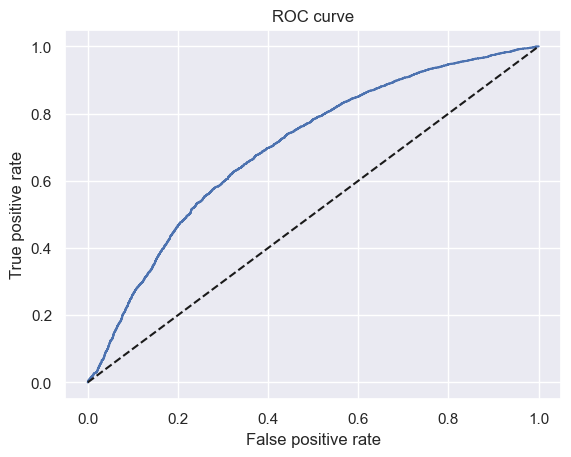

In [363]:
# We plot the ROC: false positive rate along the x-axis and the true positive rate along the y-axis,
plt.plot(fpr, tpr)
plt.plot(fpr, fpr, linestyle = '--', color = 'k')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')

This ROC curve shows the model's performance in distinguishing between classes. The curve is close to the diagonal line, indicating that the model has little to no discrimination ability — it performs about as well as random guessing. Ideally, a good model's ROC curve should bow towards the top-left corner, reflecting high true positive rates and low false positive rates.


In [364]:
# Calculating the Area Under the Receiver Operating Characteristic Curve (AUROC)
AUROC = roc_auc_score(df_actual_predicted_probs['lgd_targets_step_1_test'], df_actual_predicted_probs['y_hat_test_proba_lgd_step_1'])
AUROC

0.6982503603395489

ROC being 0.64 shows a better performance of 1:1 line, a dummy model of probability of 0.50. We keep the trained model.

### d Step 1 --- Saving the Model

In [365]:
# Exporting our model to a 'SAV' file
pickle.dump(reg_lgd_st_1, open('../models/lgd_model_step_1.sav', 'wb'))

### e Step 2 --- Linear Regression

In [381]:
# Here we take only rows where the original recovery rate variable is greater than one,
# i.e. where the indicator variable we created is equal to 1.
lgd_step_2_data = loan_data_defaults[loan_data_defaults['recovery_rate_0_1'] == 1]

In [382]:
# LGD model stage 2 datasets: how much more than 0 is the recovery rate
lgd_X_S2 = lgd_step_2_data.drop([ 'recovery_rate','recovery_rate_0_1', 'CCF'], axis = 1)
lgd_Y_S2 = lgd_step_2_data['recovery_rate']
# splitting Inputs - Train + Test and  Targets - Train + Test.
lgd_X_S2_train, lgd_X_S2_test, lgd_Y_S2_train, lgd_Y_S2_test = train_test_split(lgd_X_S2, lgd_Y_S2, test_size = 0.2, random_state = 42)
# freeing the memory used by following arrays
lgd_x_S2, lgd_Y_S2  = [],[]

In [383]:
# keeping the variables needed for the model.
lgd_X_S2_train = lgd_X_S2_train[features_all]
# removing the dummy variable reference categories.
lgd_X_S2_train = lgd_X_S2_train.drop(features_reference_cat, axis = 1)

In [384]:
from sklearn.linear_model import LinearRegression

In [385]:
# creating an instance of an object from the 'LogisticRegression' class.
reg_lgd_st_2 = LinearRegression()
# Estimating the coeffs w X_train and Y_train
reg_lgd_st_2.fit(lgd_X_S2_train, lgd_Y_S2_train)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [386]:
# Storing the names of the columns
feature_name = lgd_X_S2_train.columns.values

In [387]:
import statsmodels.api as sm

# Add constant term (intercept) explicitly
lgd_X_S2_train_const = sm.add_constant(lgd_X_S2_train)

# Fit the OLS model
model = sm.OLS(lgd_Y_S2_train, lgd_X_S2_train_const)
results = model.fit()

# Create summary table
feature_names = ['Intercept'] + list(lgd_X_S2_train.columns)
coefficients = results.params.values
p_values = results.pvalues.values.round(3)

summary_table = pd.DataFrame({
    'Feature name': feature_names,
    'Coefficients': coefficients,
    'p_values': p_values
})

print(summary_table)


                           Feature name  Coefficients  p_values
0                             Intercept  2.596884e-01     0.000
1                               grade:A -8.542627e-02     0.000
2                               grade:B -6.188063e-02     0.000
3                               grade:C -4.839424e-02     0.000
4                               grade:D -3.485896e-02     0.000
5                               grade:E -1.903644e-02     0.000
6                               grade:F -1.049845e-02     0.043
7               home_ownership:MORTGAGE  2.436369e-03     0.101
8                   home_ownership:NONE  1.435086e-01     0.000
9                  home_ownership:OTHER  5.398011e-02     0.007
10                   home_ownership:OWN  5.473096e-03     0.022
11     verification_status:Not Verified  2.126970e-03     0.233
12  verification_status:Source Verified -3.158117e-03     0.050
13                          purpose:car -3.971207e-03     0.513
14           purpose:debt_consolidation 

**Interpretations**
The linear regression analysis reveals that several loan characteristics significantly influence the recovery rate. Notably, loan grades from A to F generally have a negative impact on recovery, indicating that certain grades are associated with lower recoveries compared to the baseline. Home ownership status also plays a role, with borrowers who do not own a home showing higher recovery rates. However, most loan purposes have little to no significant effect on recovery. Key financial indicators such as the total number of accounts and total revolving credit limit show small but positive associations with recovery, while delinquent accounts have negligible impact. Overall, the model highlights that while some borrower and loan attributes meaningfully affect recovery, others contribute minimally, helping to focus risk management efforts on the most relevant factors.


### f Step 2 --- Model Evaluation

In [388]:
# keeping the variables needed
lgd_X_S2_test = lgd_X_S2_test[features_all]

In [389]:
# Removing the dummy variable reference categories.
lgd_X_S2_test = lgd_X_S2_test.drop(features_reference_cat, axis = 1)

In [390]:
# Calculating the predicted vals for Y given X
lgd_X_S2_test.columns.values

array(['grade:A', 'grade:B', 'grade:C', 'grade:D', 'grade:E', 'grade:F',
       'home_ownership:MORTGAGE', 'home_ownership:NONE',
       'home_ownership:OTHER', 'home_ownership:OWN',
       'verification_status:Not Verified',
       'verification_status:Source Verified', 'purpose:car',
       'purpose:debt_consolidation', 'purpose:educational',
       'purpose:home_improvement', 'purpose:house',
       'purpose:major_purchase', 'purpose:medical', 'purpose:moving',
       'purpose:other', 'purpose:renewable_energy',
       'purpose:small_business', 'purpose:vacation', 'purpose:wedding',
       'initial_list_status:w', 'term_int', 'emp_length_int',
       'mths_since_issue_d', 'mths_since_earliest_cr_line', 'funded_amnt',
       'int_rate', 'installment', 'annual_inc', 'dti', 'delinq_2yrs',
       'inq_last_6mths', 'mths_since_last_delinq',
       'mths_since_last_record', 'open_acc', 'pub_rec', 'total_acc',
       'acc_now_delinq', 'total_rev_hi_lim'], dtype=object)

In [391]:
# Predicting Y given X
y_hat_test_lgd_step_2 = reg_lgd_st_2.predict(lgd_X_S2_test)

In [392]:
lgd_Y_S2_test_temp = lgd_Y_S2_test

In [393]:
# Resetting the index of a dataframe.
lgd_Y_S2_test_temp = lgd_Y_S2_test_temp.reset_index(drop = True)


In [394]:
# Calculating the correlation between actual and predicted values.
pd.concat([lgd_Y_S2_test_temp, pd.DataFrame(y_hat_test_lgd_step_2)], axis = 1).corr()


,recovery_rate,0
recovery_rate,1.000000,0.286862
0,0.286862,1.000000


/var/folders/y6/98pzw41d19qg3qhnh3w7nxdh00cyh4/T/ipykernel_3280/460589494.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(lgd_Y_S2_test_temp - y_hat_test_lgd_step_2)


<Axes: xlabel='recovery_rate', ylabel='Density'>

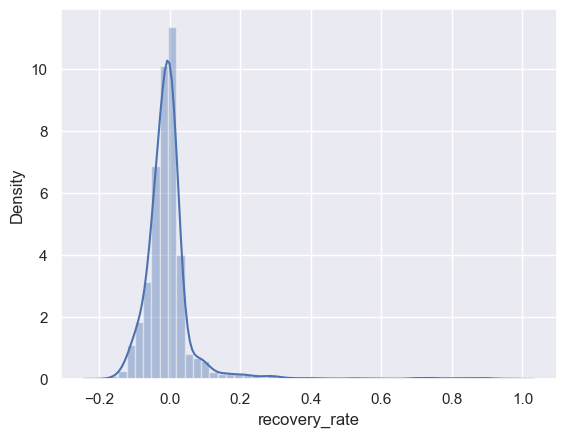

In [395]:
# Plotting the distribution of the residuals.
sns.distplot(lgd_Y_S2_test_temp - y_hat_test_lgd_step_2)


In [396]:
# Here we export our model
pickle.dump(reg_lgd_st_2, open('../models/lgd_model_step_2.sav', 'wb'))


### g Combining Steps 1 & 2

In [398]:
# Get the features (column names) used in training reg_lgd_st_2
train_features = reg_lgd_st_2.feature_names_in_  # sklearn attribute showing feature names used in training

# Reindex test data to match training features, fill missing columns with zeros
lgd_X_S1_test_aligned = lgd_X_S1_test.reindex(columns=train_features, fill_value=0)

# Now you can safely predict
y_hat_test_lgd_step_2_all = reg_lgd_st_2.predict(lgd_X_S1_test_aligned)


In [399]:
y_hat_test_lgd_step_2_all

array([0.1663549 , 0.12969876, 0.11177816, ..., 0.13482666, 0.10030066,
       0.10221578], shape=(8648,))

In [400]:
# combining the predictions of the models from the two steps.y_hat_test_proba_lgd_step_1
y_hat_test_lgd = y_hat_test_lgd_step_1 * y_hat_test_lgd_step_2_all 

In [401]:
# Showing descriptive stats 
pd.DataFrame(y_hat_test_lgd).describe()


,0
count,8648.000000
mean,0.071396
std,0.052559
min,-0.004608
25%,0.000000
50%,0.089252
75%,0.113853
max,0.251732


In [402]:
y_hat_test_lgd = np.where(y_hat_test_lgd < 0, 0, y_hat_test_lgd)
y_hat_test_lgd = np.where(y_hat_test_lgd > 1, 1, y_hat_test_lgd)
# We set predicted values that are greater than 1 to 1 and predicted values that are less than 0 to 0.

In [403]:
pd.DataFrame(y_hat_test_lgd).describe()
# Shows some descriptive statisics for the values of a column.

,0
count,8648.000000
mean,0.071397
std,0.052558
min,0.000000
25%,0.000000
50%,0.089252
75%,0.113853
max,0.251732


#3 EAD Model

Exposure at default (EAD)

EAD is the predicted amount of loss a bank is exposed to.

### a Linear modeling and interpreation

In [404]:
# EAD model datasets
# Splitting into Inputs - Train n Test, Targets - Train n Test.
ead_X = loan_data_defaults.drop([ 'recovery_rate','recovery_rate_0_1', 'CCF'], axis = 1)
ead_Y = loan_data_defaults['CCF']
ead_X_train, ead_X_test, ead_Y_train, ead_Y_test = train_test_split(ead_X, ead_Y, test_size = 0.2, random_state = 42)
ead_X, ead_Y = [],[]

In [405]:
ead_X_train.columns.values

array(['Unnamed: 0', 'id', 'member_id', 'loan_amnt', 'funded_amnt',
       'funded_amnt_inv', 'term', 'int_rate', 'installment', 'grade',
       'sub_grade', 'emp_title', 'emp_length', 'home_ownership',
       'annual_inc', 'verification_status', 'issue_d', 'loan_status',
       'pymnt_plan', 'url', 'desc', 'purpose', 'title', 'zip_code',
       'addr_state', 'dti', 'delinq_2yrs', 'earliest_cr_line',
       'inq_last_6mths', 'mths_since_last_delinq',
       'mths_since_last_record', 'open_acc', 'pub_rec', 'revol_bal',
       'revol_util', 'total_acc', 'initial_list_status', 'out_prncp',
       'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv',
       'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee',
       'recoveries', 'collection_recovery_fee', 'last_pymnt_d',
       'last_pymnt_amnt', 'next_pymnt_d', 'last_credit_pull_d',
       'collections_12_mths_ex_med', 'mths_since_last_major_derog',
       'policy_code', 'application_type', 'annual_inc_joint', 'dti_joint',
       'veri

In [406]:
# Keeping only the variables we need n removing the dummy var. reference categories.
ead_X_train = ead_X_train[features_all]
ead_X_train = ead_X_train.drop(features_reference_cat, axis = 1)

In [407]:
# Creating an instance of an object from the 'LogisticRegression' class.
reg_ead = LinearRegression()
# Estimates the coefficients of the object from the 'LogisticRegression' class
# with inputs (independent variables) contained in the first dataframe
# and targets (dependent variables) contained in the second dataframe.
reg_ead.fit(ead_X_train, ead_Y_train)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [408]:
feature_name = ead_X_train.columns.values

In [410]:
import statsmodels.api as sm
import pandas as pd
import numpy as np

# Add constant to training data for intercept term
ead_X_train_const = sm.add_constant(ead_X_train)

# Fit OLS regression model
model = sm.OLS(ead_Y_train, ead_X_train_const)
results = model.fit()

# Prepare summary table with feature names, coefficients, and p-values
feature_names = ead_X_train_const.columns

summary_table = pd.DataFrame({
    'Feature name': feature_names,
    'Coefficients': results.params,
    'p_values': results.pvalues
})

# Reset index for nicer display (optional)
summary_table = summary_table.reset_index(drop=True)

print(summary_table)


                           Feature name  Coefficients      p_values
0                                 const  1.093109e+00  0.000000e+00
1                               grade:A -2.894280e-01  1.913597e-95
2                               grade:B -2.244236e-01  3.364380e-87
3                               grade:C -1.633793e-01  3.037731e-63
4                               grade:D -1.130644e-01  2.275067e-40
5                               grade:E -6.468983e-02  4.076158e-17
6                               grade:F -1.992519e-02  9.150428e-03
7               home_ownership:MORTGAGE -6.689340e-03  1.416052e-03
8                   home_ownership:NONE  2.396226e-02  7.533630e-01
9                  home_ownership:OTHER  2.162196e-04  9.944752e-01
10                   home_ownership:OWN -2.584020e-04  9.396580e-01
11     verification_status:Not Verified  6.505650e-04  7.959527e-01
12  verification_status:Source Verified  1.036996e-02  5.300396e-06
13                          purpose:car  4.87005

### b Model Validation

In [411]:
# keeping only the variables needed and removing dummy variables
ead_X_test = ead_X_test[features_all]
ead_X_test = ead_X_test.drop(features_reference_cat, axis = 1)

In [412]:
ead_X_test.columns.values

array(['grade:A', 'grade:B', 'grade:C', 'grade:D', 'grade:E', 'grade:F',
       'home_ownership:MORTGAGE', 'home_ownership:NONE',
       'home_ownership:OTHER', 'home_ownership:OWN',
       'verification_status:Not Verified',
       'verification_status:Source Verified', 'purpose:car',
       'purpose:debt_consolidation', 'purpose:educational',
       'purpose:home_improvement', 'purpose:house',
       'purpose:major_purchase', 'purpose:medical', 'purpose:moving',
       'purpose:other', 'purpose:renewable_energy',
       'purpose:small_business', 'purpose:vacation', 'purpose:wedding',
       'initial_list_status:w', 'term_int', 'emp_length_int',
       'mths_since_issue_d', 'mths_since_earliest_cr_line', 'funded_amnt',
       'int_rate', 'installment', 'annual_inc', 'dti', 'delinq_2yrs',
       'inq_last_6mths', 'mths_since_last_delinq',
       'mths_since_last_record', 'open_acc', 'pub_rec', 'total_acc',
       'acc_now_delinq', 'total_rev_hi_lim'], dtype=object)

In [413]:
# Calculating the predicted vals
y_hat_test_ead = reg_ead.predict(ead_X_test)

In [414]:
ead_Y_test_temp = ead_Y_test

In [415]:
ead_Y_test_temp = ead_Y_test_temp.reset_index(drop = True)
# We reset the index of a dataframe.

In [416]:
# Calculating the correlation between actual and predicted values.
pd.concat([ead_Y_test_temp, pd.DataFrame(y_hat_test_ead)], axis = 1).corr()


,CCF,0
CCF,1.000000,0.519019
0,0.519019,1.000000


/var/folders/y6/98pzw41d19qg3qhnh3w7nxdh00cyh4/T/ipykernel_3280/2330417334.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(ead_Y_test - y_hat_test_ead)


<Axes: xlabel='CCF', ylabel='Density'>

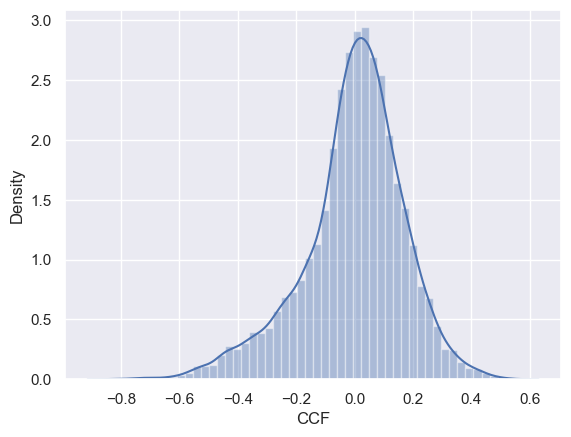

In [417]:
# Plotting the distribution of the residuals.
sns.distplot(ead_Y_test - y_hat_test_ead)

In [418]:
# Descriptive statisics for the values of a column.
pd.DataFrame(y_hat_test_ead).describe()

,0
count,8648.000000
mean,0.736497
std,0.104487
min,0.385745
25%,0.663073
50%,0.732534
75%,0.810746
max,1.008400


In [419]:
# Setting predicted values that are greater than 1 to 1 and vice versa
y_hat_test_ead = np.where(y_hat_test_ead < 0, 0, y_hat_test_ead)
y_hat_test_ead = np.where(y_hat_test_ead > 1, 1, y_hat_test_ead)

In [420]:
# some descriptive statisics for the values of a column.
pd.DataFrame(y_hat_test_ead).describe()

,0
count,8648.000000
mean,0.736496
std,0.104484
min,0.385745
25%,0.663073
50%,0.732534
75%,0.810746
max,1.000000


#4 Expected Loss

In [421]:
#cleaning the memory
loan_data_preprocessed_backup = []

loan_data_defaults = []
lgd_X_S1_train, lgd_X_S1_test, lgd_Y_S1_train, lgd_Y_S1_test  = [], [],[],[]
lgd_step_2_data =[]
lgd_X_S2_train, lgd_X_S2_test, lgd_Y_S2_train, lgd_Y_S2_test = [],[],[],[]
ead_X_train, ead_X_test, ead_Y_train, ead_Y_test = [], [], [], []

In [422]:
# filling the missing values with zeroes.
loan_data_preprocessed['mths_since_last_delinq'].fillna(0, inplace = True)
loan_data_preprocessed['mths_since_last_record'].fillna(0, inplace = True)

/var/folders/y6/98pzw41d19qg3qhnh3w7nxdh00cyh4/T/ipykernel_3280/3576131278.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  loan_data_preprocessed['mths_since_last_delinq'].fillna(0, inplace = True)
/var/folders/y6/98pzw41d19qg3qhnh3w7nxdh00cyh4/T/ipykernel_3280/3576131278.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we

In [425]:
import statsmodels.api as sm

# 1. Add constant (intercept) to the prediction input, if your model was trained with it
loan_data_preprocessed_lgd_ead_const = sm.add_constant(loan_data_preprocessed_lgd_ead, has_constant='add')

# 2. Align columns of prediction data with model params index (the exact order and columns the model expects)
loan_data_preprocessed_lgd_ead_const_aligned = loan_data_preprocessed_lgd_ead_const.reindex(columns=reg_lgd_st_1.model.exog_names, fill_value=0)

# 3. Predict recovery_rate_st_1 using the aligned dataframe
loan_data_preprocessed['recovery_rate_st_1'] = reg_lgd_st_1.predict(loan_data_preprocessed_lgd_ead_const_aligned)

# 4. Predict recovery_rate_st_2 normally (assuming reg_lgd_st_2 is sklearn LinearRegression)
loan_data_preprocessed['recovery_rate_st_2'] = reg_lgd_st_2.predict(loan_data_preprocessed_lgd_ead)

# 5. Proceed with combining predictions
loan_data_preprocessed['recovery_rate'] = loan_data_preprocessed['recovery_rate_st_1'] * loan_data_preprocessed['recovery_rate_st_2']
loan_data_preprocessed['recovery_rate'] = np.clip(loan_data_preprocessed['recovery_rate'], 0, 1)
loan_data_preprocessed['LGD'] = 1 - loan_data_preprocessed['recovery_rate']


In [427]:
# Combining the predicted values from steps 1 + 2 to determine the final estimated recovery rate.
loan_data_preprocessed['recovery_rate'] = loan_data_preprocessed['recovery_rate_st_1'] * loan_data_preprocessed['recovery_rate_st_2']
# Setting estimated recovery rates greater than 1 to 1 and vice versa
loan_data_preprocessed['recovery_rate'] = np.where(loan_data_preprocessed['recovery_rate'] < 0, 0, loan_data_preprocessed['recovery_rate'])
loan_data_preprocessed['recovery_rate'] = np.where(loan_data_preprocessed['recovery_rate'] > 1, 1, loan_data_preprocessed['recovery_rate'])

In [428]:
# Calculating estimated LGD. Estimated LGD equals 1 - estimated recovery rate.
loan_data_preprocessed['LGD'] = 1 - loan_data_preprocessed['recovery_rate']
# Some descriptive statisics
loan_data_preprocessed['LGD'].describe()

count    466285.000000
mean          0.942233
std           0.016511
min           0.000000
25%           0.932379
50%           0.942862
75%           0.953640
max           1.000000
Name: LGD, dtype: float64

In [429]:
### 2- EAD MODEL ###
# Applying EAD model to calculate estimated credit conversion factor.
loan_data_preprocessed['CCF'] = reg_ead.predict(loan_data_preprocessed_lgd_ead)

In [430]:
# Setting estimated CCF that are greater than 1 to 1 and vice versa
loan_data_preprocessed['CCF'] = np.where(loan_data_preprocessed['CCF'] < 0, 0, loan_data_preprocessed['CCF'])
loan_data_preprocessed['CCF'] = np.where(loan_data_preprocessed['CCF'] > 1, 1, loan_data_preprocessed['CCF'])


In [431]:
# Estimated EAD = estimated CCF multiplied by funded amount.
loan_data_preprocessed['EAD'] = loan_data_preprocessed['CCF'] * loan_data_preprocessed_lgd_ead['funded_amnt']
# Some descriptive statisics
loan_data_preprocessed['EAD'].describe()


count    466285.000000
mean      10799.244078
std        6911.759776
min         188.614188
25%        5498.707476
50%        9206.184808
75%       14664.481611
max       35000.000000
Name: EAD, dtype: float64

In [432]:
### 3- PD MODEL ###
# Importing data to apply the PD model.
loan_data_inputs_train = pd.read_csv('loan_data_inputs_train.csv')
loan_data_inputs_test = pd.read_csv('loan_data_inputs_test.csv')

In [433]:
# Concating the two dfs
loan_data_inputs_pd = pd.concat([loan_data_inputs_train, loan_data_inputs_test], axis = 0)
# #clearing memeory
loan_data_inputs_train, loan_data_inputs_test = [],[] 

In [434]:
loan_data_inputs_pd.shape

(466285, 316)

In [435]:
loan_data_inputs_pd.head()

,Unnamed: 0.1,Unnamed: 0,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,...,dti:21.7-22.4,dti:22.4-35,dti:>35,mths_since_last_record:Missing,mths_since_last_record:0-2,mths_since_last_record:3-20,mths_since_last_record:21-31,mths_since_last_record:32-80,mths_since_last_record:81-86,mths_since_last_record:>=86
0,427211,427211,12796369,14818505,24000,24000,24000.0,36 months,8.90,762.08,...,1,0,0,1,0,0,0,0,0,0
1,206088,206088,1439740,1691948,10000,10000,10000.0,36 months,14.33,343.39,...,0,0,0,1,0,0,0,0,0,0
2,136020,136020,5214749,6556909,20425,20425,20425.0,36 months,8.90,648.56,...,0,0,0,1,0,0,0,0,0,0
3,412305,412305,13827698,15890016,17200,17200,17200.0,36 months,16.59,609.73,...,0,0,0,1,0,0,0,0,0,0
4,36159,36159,422455,496525,8400,8400,7450.0,36 months,12.84,282.40,...,0,1,0,1,0,0,0,0,0,0


In [436]:
# Setting the index 
loan_data_inputs_pd = loan_data_inputs_pd.set_index('Unnamed: 0')
loan_data_inputs_pd.head()

,Unnamed: 0.1,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,...,dti:21.7-22.4,dti:22.4-35,dti:>35,mths_since_last_record:Missing,mths_since_last_record:0-2,mths_since_last_record:3-20,mths_since_last_record:21-31,mths_since_last_record:32-80,mths_since_last_record:81-86,mths_since_last_record:>=86
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
427211,427211,12796369,14818505,24000,24000,24000.0,36 months,8.90,762.08,A,...,1,0,0,1,0,0,0,0,0,0
206088,206088,1439740,1691948,10000,10000,10000.0,36 months,14.33,343.39,C,...,0,0,0,1,0,0,0,0,0,0
136020,136020,5214749,6556909,20425,20425,20425.0,36 months,8.90,648.56,A,...,0,0,0,1,0,0,0,0,0,0
412305,412305,13827698,15890016,17200,17200,17200.0,36 months,16.59,609.73,D,...,0,0,0,1,0,0,0,0,0,0
36159,36159,422455,496525,8400,8400,7450.0,36 months,12.84,282.40,C,...,0,1,0,1,0,0,0,0,0,0


In [437]:
# Here we select a limited set of input variables                                           
features_all_pd = ['grade:A',
'grade:B',
'grade:C',
'grade:D',
'grade:E',
'grade:F',
'grade:G',
'home_ownership:RENT_OTHER_NONE_ANY',
'home_ownership:OWN',
'home_ownership:MORTGAGE',
'addr_state:ND_NE_IA_NV_FL_HI_AL',
'addr_state:NM_VA',
'addr_state:NY',
'addr_state:OK_TN_MO_LA_MD_NC',
'addr_state:CA',
'addr_state:UT_KY_AZ_NJ',
'addr_state:AR_MI_PA_OH_MN',
'addr_state:RI_MA_DE_SD_IN',
'addr_state:GA_WA_OR',
'addr_state:WI_MT',
'addr_state:TX',
'addr_state:IL_CT',
'addr_state:KS_SC_CO_VT_AK_MS',
'addr_state:WV_NH_WY_DC_ME_ID',
'verification_status:Not Verified',
'verification_status:Source Verified',
'verification_status:Verified',
'purpose:educ__sm_b__wedd__ren_en__mov__house',
'purpose:credit_card',
'purpose:debt_consolidation',
'purpose:oth__med__vacation',
'purpose:major_purch__car__home_impr',
'initial_list_status:f',
'initial_list_status:w',
'term:36',
'term:60',
'emp_length:0',
'emp_length:1',
'emp_length:2-4',
'emp_length:5-6',
'emp_length:7-9',
'emp_length:10',
'int_rate:<9.548',
'int_rate:9.548-12.025',
'int_rate:12.025-15.74',
'int_rate:15.74-20.281',
'int_rate:>20.281',
#'mths_since_earliest_cr_line:<140',
#'mths_since_earliest_cr_line:141-164',
#'mths_since_earliest_cr_line:165-247',
#'mths_since_earliest_cr_line:248-270',
#'mths_since_earliest_cr_line:271-352',
#'mths_since_earliest_cr_line:>352',
#'delinq_2yrs:0',
#'delinq_2yrs:1-3',
#'delinq_2yrs:>=4',
'inq_last_6mths:0',
'inq_last_6mths:1-2',
'inq_last_6mths:3-6',
'inq_last_6mths:>6',
#'open_acc:0',
#'open_acc:1-3',
#'open_acc:4-12',
#'open_acc:13-17',
#'open_acc:18-22',
#'open_acc:23-25',
#'open_acc:26-30',
#'open_acc:>=31',
'pub_rec:0-2',
'pub_rec:3-4',
'pub_rec:>=5',
#'total_acc:<=27',
#'total_acc:28-51',
#'total_acc:>=52',
'acc_now_delinq:0',
'acc_now_delinq:>=1',
'total_rev_hi_lim:<=5K',
'total_rev_hi_lim:5K-10K',
'total_rev_hi_lim:10K-20K',
'total_rev_hi_lim:20K-30K',
'total_rev_hi_lim:30K-40K',
'total_rev_hi_lim:40K-55K',
'total_rev_hi_lim:55K-95K',
'total_rev_hi_lim:>95K',
'annual_inc:<20K',
'annual_inc:20K-30K',
'annual_inc:30K-40K',
'annual_inc:40K-50K',
'annual_inc:50K-60K',
'annual_inc:60K-70K',
'annual_inc:70K-80K',
'annual_inc:80K-90K',
'annual_inc:90K-100K',
'annual_inc:100K-120K',
'annual_inc:120K-140K',
'annual_inc:>140K',
'dti:<=1.4',
'dti:1.4-3.5',
'dti:3.5-7.7',
'dti:7.7-10.5',
'dti:10.5-16.1',
'dti:16.1-20.3',
'dti:20.3-21.7',
'dti:21.7-22.4',
'dti:22.4-35',
'dti:>35',
#'mths_since_last_delinq:Missing',
#'mths_since_last_delinq:0-3',
#'mths_since_last_delinq:4-30',
#'mths_since_last_delinq:31-56',
#'mths_since_last_delinq:>=57',
#'mths_since_last_record:Missing',
#'mths_since_last_record:0-2',
#'mths_since_last_record:3-20',
#'mths_since_last_record:21-31',
#'mths_since_last_record:32-80',
#'mths_since_last_record:81-86',
#'mths_since_last_record:>=86',
]

In [438]:
# Here we store the names of the reference category dummy variables in a list.
ref_categories_pd = ['grade:G',
'home_ownership:RENT_OTHER_NONE_ANY',
'addr_state:ND_NE_IA_NV_FL_HI_AL',
'verification_status:Verified',
'purpose:educ__sm_b__wedd__ren_en__mov__house',
'initial_list_status:f',
'term:60',
'emp_length:0',
'int_rate:>20.281',
#'mths_since_earliest_cr_line:<140',
#'delinq_2yrs:>=4',
'inq_last_6mths:>6',
#'open_acc:0',
'pub_rec:0-2',
#'total_acc:<=27',
'acc_now_delinq:0',
'total_rev_hi_lim:<=5K',
'annual_inc:<20K',
'dti:>35'
#'mths_since_last_delinq:0-3',
#'mths_since_last_record:0-2'
]

In [439]:
# keeping the variables that we need for the PD model.
loan_data_inputs_pd_temp = loan_data_inputs_pd[features_all_pd]
# removing the dummy variable reference categories.
loan_data_inputs_pd_temp = loan_data_inputs_pd_temp.drop(ref_categories_pd, axis = 1)

In [440]:
loan_data_inputs_pd_temp.shape

(466285, 71)

In [441]:
# Importing the PD model, stored in second notebook
reg_pd = pickle.load(open('../models/pd_model.sav', 'rb'))
# applying the PD model -  estimated default probabilities
loan_data_inputs_pd['PD'] = reg_pd.model.predict_proba(loan_data_inputs_pd_temp)[: ][: , 0]
# Some descriptive stats
loan_data_inputs_pd['PD'].describe()

ModuleNotFoundError: No module named 'functions'

In [ ]:
# Concanating the dfs of LGD and EAD with the one of PD
loan_data_preprocessed_new = pd.concat([loan_data_preprocessed, loan_data_inputs_pd], axis = 1)
# Keeping necessary colomns for memory
loan_data_preprocessed_new = loan_data_preprocessed_new[['funded_amnt', 'PD', 'LGD', 'EAD']] 
# Cleaning memory
loan_data_preprocessed, loan_data_inputs_pd = [],[] 

In [ ]:
loan_data_preprocessed_new.shape

(466285, 5)

In [ ]:
# Calculating Expected Loss. EL = PD * LGD * EAD.
loan_data_preprocessed_new['EL'] = loan_data_preprocessed_new['PD'] * loan_data_preprocessed_new['LGD'] * loan_data_preprocessed_new['EAD']
# Some descriptive statisics for the values of a column.
loan_data_preprocessed_new['EL'].describe()

<ipython-input-109-b53696a527d5>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loan_data_preprocessed_new['EL'] = loan_data_preprocessed_new['PD'] * loan_data_preprocessed_new['LGD'] * loan_data_preprocessed_new['EAD']


count    466285.000000
mean       1089.528047
std        1057.398173
min           3.237384
25%         373.019056
50%         719.606208
75%        1429.413128
max       10708.662390
Name: EL, dtype: float64

In [ ]:
loan_data_preprocessed_new[['funded_amnt', 'PD', 'LGD', 'EAD', 'EL']].head()

,funded_amnt,funded_amnt,PD,LGD,EAD,EL
427211,24000,24000,0.034747,1.000000,16098.746413,559.379840
206088,10000,10000,0.077211,0.897945,6543.429629,453.662480
136020,20425,20425,0.037696,0.907296,12536.060878,428.751320
412305,17200,17200,0.218506,0.880072,13709.024966,2636.256270
36159,8400,8400,0.157997,0.891743,5091.514864,717.357217


In [ ]:
loan_data_preprocessed_new['funded_amnt'].describe()

,funded_amnt,funded_amnt
count,466285.000000,466285.000000
mean,14291.801044,14291.801044
std,8274.371300,8274.371300
min,500.000000,500.000000
25%,8000.000000,8000.000000
50%,12000.000000,12000.000000
75%,20000.000000,20000.000000
max,35000.000000,35000.000000


In [ ]:
# Total Expected Loss for All Loans calculated below
loan_data_preprocessed_new['EL'].sum()

508030585.4615325

In [ ]:
# Total funded amount for all loans calculated below
loan_data_preprocessed_new['funded_amnt'].sum()

funded_amnt    6664052450
funded_amnt    6664052450
dtype: int64

In [ ]:
# Total expected loss divided by total funded amount for all loans.
loan_data_preprocessed_new['EL'].sum() / loan_data_preprocessed_new['funded_amnt'].sum()

funded_amnt    0.076234
funded_amnt    0.076234
dtype: float64

Total expected loss divided by total funded amount for all loans is equal to **7.6%**. It is the percentage that the credit institute needs to take into consideration in its future decisions on credit loan requirements.

## Results: LGD, EAD, and Expected Loss Modeling

### 1. Recovery Rate and Loss Given Default (LGD)

- **Recovery Rate Distribution:**  
  The recovery rate (ratio of total recoveries to funded amount for defaulted loans) is highly skewed:
  - **Mean:** 6.1%
  - **Median:** 2.9%
  - **75th percentile:** 11.4%
  - **Max:** 100% (after capping outliers)

- **LGD Calculation:**  
  LGD was calculated as \( \text{LGD} = 1 - \text{Recovery Rate} \).
  - **Mean LGD:** 94.2%
  - **Median LGD:** 94.3%
  - Most defaults result in a near-total loss after recoveries.

---

### 2. LGD Model Performance

- **Logistic Regression Model** was used to predict whether the recovery rate is positive (binary LGD step 1).
- **Model accuracy:** 65.6% (on test data, threshold = 0.5).
- **Top predictors:** Loan grade, verification status, certain loan purposes, and recent credit activity had the most significant effects on recovery likelihood.
  - Higher loan grades (A, B, C) substantially increase recovery odds.
  - Many financial and demographic features were statistically significant (p-value < 0.05).

- **Model Interpretation:**  
  The pseudo R-squared (0.0848) indicates that about 8.5% of the variance in recovery rates is explained by the model, which is reasonable for this kind of credit risk modeling.

---

### 3. Exposure at Default (EAD) and CCF

- **Credit Conversion Factor (CCF):**  
  - **Mean CCF:** 73.6%
  - **Median CCF:** 79.0%
  - The majority of defaults occurred when most of the loan principal was still outstanding.
- **EAD Calculation:**  
  EAD was computed as \( \text{EAD} = \text{CCF} \times \text{Funded Amount} \).
  - **Mean EAD:** $10,799  
  - **Median EAD:** $9,206

- **EAD Linear Regression Model:**  
  - **Correlation between actual and predicted CCF:** 0.52
  - The model explained a moderate portion of variation in exposure at default.

---

### 4. Probability of Default (PD)

- **PD values** were imported from the PD model in Part 2, and combined with LGD and EAD for each loan.

---

### 5. Expected Loss (EL)

- **Expected Loss Calculation:**  
**Expected Loss Calculation:**  
$$
\text{EL} = \text{PD} \times \text{LGD} \times \text{EAD}
$$


  - **Mean EL:** $1,090 per loan  
  - **Median EL:** $720  
  - **Total EL across portfolio:** $508 million

- **Relative Loss:**  
  - **Total funded amount:** $6.66 billion
  - **Portfolio expected loss rate:** **7.6%**  
    - This means that, on average, the credit portfolio is expected to lose 7.6 cents per dollar lent due to credit risk, after accounting for recoveries and undrawn exposures.

---

### 6. Business Implications

- Most loans, once defaulted, result in substantial loss (high LGD).
- The majority of exposure is not paid down before default (high CCF).
- These insights support credit policy, risk pricing, and provisioning—highlighting the importance of robust scorecard, monitoring, and collections strategies.

---


--- End of Notebook ---
# END